In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import initializers
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
train = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=False,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

val = image_dataset_from_directory(
    'data/val/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

test = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    label_mode='int',
    class_names=['0', '1', '5', '7', '8'],
    batch_size=1,
    image_size=(28, 28),
    shuffle=False,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

Found 11385 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.


In [56]:
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

In [17]:
model_dir = 'models/'

# Get training and validation accuracies for every trained model

accuracies = dict()

for model in os.listdir(model_dir):
    model_path = os.path.join(model_dir, model)
    trained_model = tf.keras.models.load_model(model_path) # load model
    train_acc = trained_model.evaluate(train, verbose=0)[1]
    val_acc = trained_model.evaluate(val, verbose=0)[1]
    accuracies[model[:-3]] = [train_acc, val_acc]

In [20]:
import pickle
with open('accuracies.pkl', 'wb') as fp:
    pickle.dump(accuracies, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [1]:
import pickle
with open('accuracies.pkl', 'rb') as fp:
    read_file = pickle.load(fp)

{'adagrad-16-16-16': [0.20000000298023224, 0.20000000298023224], 'adagrad-16-32-64': [0.20000000298023224, 0.20000000298023224], 'adagrad-16-8-4': [0.20000000298023224, 0.20000000298023224], 'adagrad-32-16-4': [0.20000000298023224, 0.20000000298023224], 'adagrad-32-32-32': [0.20000000298023224, 0.20000000298023224], 'adagrad-4-16-32': [0.20000000298023224, 0.20000000298023224], 'adagrad-4-4-4': [0.20000000298023224, 0.20000000298023224], 'adagrad-4-8-16': [0.20000000298023224, 0.20000000298023224], 'adagrad-64-32-16': [0.20000000298023224, 0.20000000298023224], 'adagrad-8-8-8': [0.20000000298023224, 0.20000000298023224], 'adam-16-16-16': [0.9887571334838867, 0.9694334864616394], 'adam-16-32-64': [0.991919219493866, 0.9723320007324219], 'adam-16-8-4': [0.9871761202812195, 0.9670619368553162], 'adam-32-16-4': [0.9934123754501343, 0.9720684885978699], 'adam-32-32-32': [0.9896354675292969, 0.9747035503387451], 'adam-4-16-32': [0.9798858165740967, 0.9581027626991272], 'adam-4-4-4': [0.97277

In [10]:
acc = []
arch = []
import numpy as np
for i in read_file.keys():
    acc.append(read_file[i])
    arch.append(i)

In [14]:
import pandas as pd
a = pd.DataFrame()
a['arch'] = arch
a['tr'] = np.array(acc)[:, 0]
a['val'] = np.array(acc)[:, 1]
a.to_csv('acc.csv')

In [3]:
best_optim = 'adam'
best_arch = '64-32-16'
best_model = tf.keras.models.load_model('models/' + best_optim + '-' + best_arch + '.tf')

In [49]:
model_acc_train = best_model.evaluate(train, batch_size=1, return_dict=True)
model_acc_test = best_model.evaluate(test, batch_size=1, return_dict=True)

3795/3795 [==============================] - 3s 767us/step - loss: 0.0818 - accuracy: 0.9810


In [57]:
test_pred = best_model.predict(test)
train_pred = best_model.predict(train)

pred_class_test = np.argmax(test_pred, axis=1)
pred_class_train = np.argmax(train_pred, axis=1)

y_test = np.concatenate([y for x, y in test], axis=0)
y_train = np.concatenate([y for x, y in train], axis=0)

11385/11385 [==============================] - 8s 713us/step


In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix
test_score = accuracy_score(y_test, pred_class_test)
train_score = accuracy_score(y_train, pred_class_train)

print('accuracy score (test):', test_score)
print('accuracy score (train):', train_score)

accuracy score (test): 0.9810276679841897
accuracy score (train): 0.9956960913482653


confusion matrix (test):


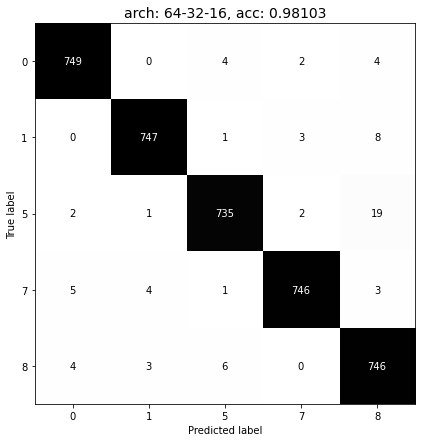

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay
print('confusion matrix (test):')
fig = plt.figure(figsize=(7, 7))
#fig.suptitle('Confusion Matrix (Test Set)', y=0.04, fontsize=15)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, pred_class_test), display_labels=['0', '1', '5', '7', '8'])
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
ax.set_title(f'arch: {best_arch}, acc: {np.round(test_score, 5)}', fontdict = {'fontsize':14}, )
plt.show()

confusion matrix (train):


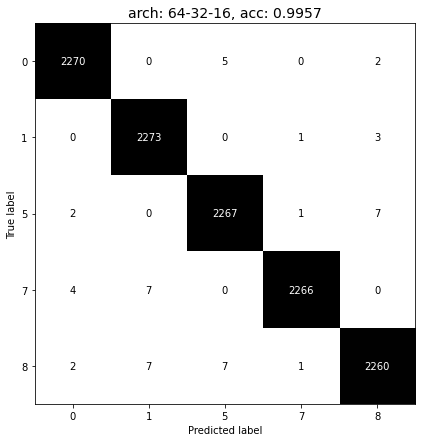

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
print('confusion matrix (train):')
fig = plt.figure(figsize=(7, 7))
#fig.suptitle('Confusion Matrix (Test Set)', y=0.04, fontsize=15)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, pred_class_train), display_labels=['0', '1', '5', '7', '8'])
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
ax.set_title(f'arch: {best_arch}, acc: {np.round(train_score, 5)}', fontdict = {'fontsize':14}, )
plt.show()

In [4]:
best_model.save('best_model.h5')